# Capacity prediction

## Notebook 4: Regression Model 

**Author:** ACG  
**Date:** `2024/06`  
**Version:** 1.0  

---

### Table of Contents
1. [Linear Regression](#linear-regression)
2. [Tree Regression](#tree-regression)
3. [XGBoost](#xgb-regression)

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from utils.properties import *
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
seed = 1862

## Import Dataset

In [3]:
df = pd.read_csv(DATASET_FINAL, sep=';')
df_features = df.drop(['capacity'], axis=1)
df_target = df['capacity']

In [4]:
df_target.describe()

count    588.000000
mean      32.005102
std        7.193479
min       15.000000
25%       26.000000
50%       32.000000
75%       37.000000
max       53.000000
Name: capacity, dtype: float64

In [5]:
df.isna().sum()

sector_area                   0
lowest_bound                  0
num_airblocks_avg             0
attitude_cruise_cruise        0
avg_nFlights                  0
median_complexity             0
std_complexity                0
max_harmonic_complexity       0
median_harmonic_complexity    0
std_harmonic_complexity       0
avg_occ_w1                    0
median_ent_w1                 0
avg_occ_w5                    0
avg_ent_w5                    0
Q75_ent_5                     0
avg_occ_w10                   0
avg_ent_w10                   0
avg_ent_w60                   0
max_occupancyInWindow_1       0
max_occupancyInWindow_5       0
max_occupancyInWindow_10      0
max_entriesInWindow_10        0
max_entriesInWindow_60        0
duration_days                 0
year_from                     0
year_to                       0
atcunit_code                  0
sector_code                   0
approximation_route           0
ground                        0
ceiling                       0
volume_w

We want to start from a simple regression model, then go up from there.

# 1. Linear Regression <a id="linear-regression"></a>

Because the model parameters have a relatively low correlation with the target (aprox. 40%), it suggests a weak linear correlation. The linear regression model is thus expected to perform the worst. Here we apply feature normalization with StandardScaler, but for the other models it is not required since they are tree based.

## Train

In [6]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)

In [7]:
scaler = StandardScaler()
algorithm = LinearRegression()

model_lr = Pipeline([
    ('scaler', scaler),
    ('algorithm', algorithm)
])
model_lr.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('algorithm', LinearRegression())])

In [8]:
y_pred = model_lr.predict(x_test)

## Evaluation

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

In [9]:
print(f"R^2 train: {model_lr.score(x_train,y_train)}")
print(f"R^2 test: {model_lr.score(x_test,y_test)}")

R^2 train: 0.5707893690113799
R^2 test: 0.5437714265665162


As seen from the R squared, the model is capturing some of the target's variance but definetely not a large proportion. The similar results in train and test suggest there is no overfitting, however the low values could possibly represent underfitting, there is certainly room for improvement.

### Error

In [10]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 3.868562953859399
MSE: 21.744186708597812
RMSE: 4.663066234635512


On average the predictions with the linear model differ from the actual value by 3.86 units. The RMSE is more sensitive to larger errors then MAE, so a value of 4.66 after taking into account the MAE suggests that there are indeed larger errors, but they aren't extremely large.

### Plots

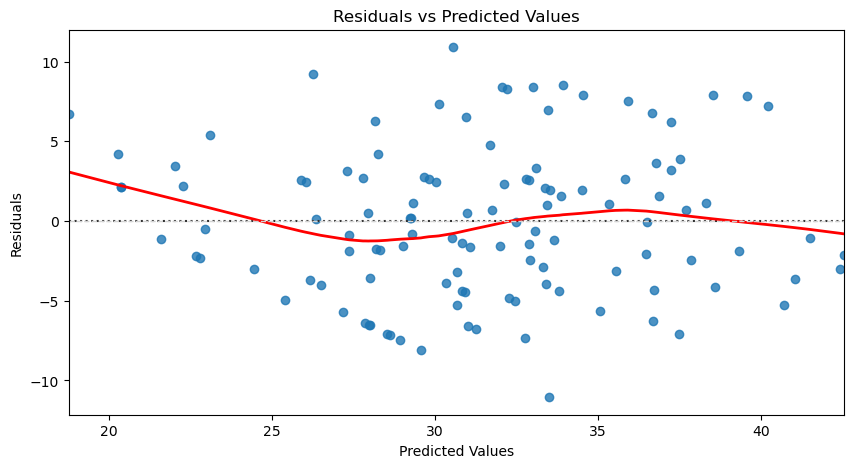

In [11]:
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

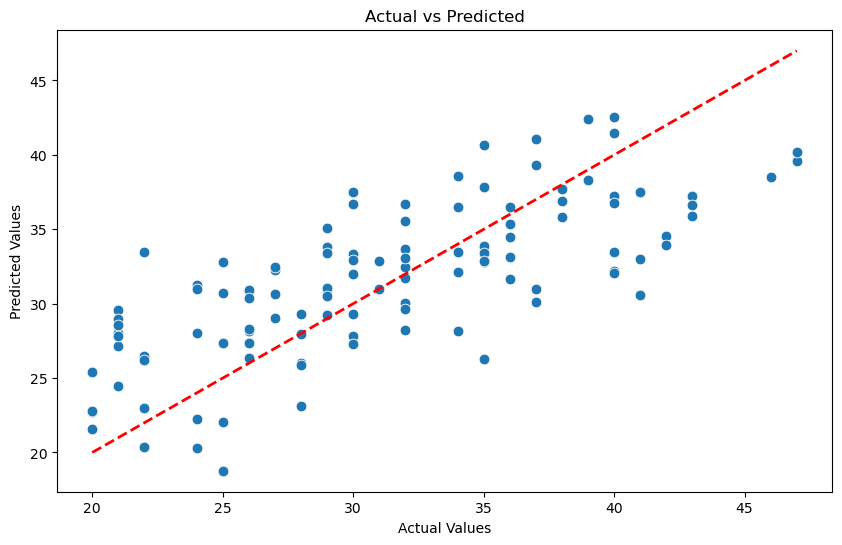

In [12]:
plt.figure(figsize=(10, 6))
sbn.scatterplot(x=y_test, y=y_pred, s=60)
sbn.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

# 2. Tree Regression <a id="tree-regression"></a>

In [13]:
from sklearn.tree import DecisionTreeRegressor

In a decision tree model we will need to tune different hyperparameters to achieve optimal results:
1. **max_depth**: the depth of the tree, a greater value means more accuracy but also more computational time.
2. **min_samples_split**: the minimum number of samples required to split a node
3. **criterion**: function used to measure the quality of a split (Squared error, absolute error, etc.)

## Train

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)
tree_base = DecisionTreeRegressor(random_state=seed)

In [15]:
params = {
    'max_depth': [5,8,12,18,25],
    'min_samples_split': [3, 9, 18, 40, 80, 120],
    'criterion': ["squared_error","poisson","absolute_error"]
}
metrics = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [16]:
gs = GridSearchCV(
    estimator=tree_base,
    param_grid=params,
    cv=4,
    scoring=metrics,
    refit='r2'
)
gs.fit(x_train,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=1862),
             param_grid={'criterion': ['squared_error', 'poisson',
                                       'absolute_error'],
                         'max_depth': [5, 8, 12, 18, 25],
                         'min_samples_split': [3, 9, 18, 40, 80, 120]},
             refit='r2', scoring=['r2'])

## Evaluation

In [17]:
best_model_tr = gs.best_estimator_
y_pred = best_model_tr.predict(x_test)

print(best_model_tr)
print(f"parameters: {gs.best_params_}")
print(f"R squared: {gs.best_score_}")

DecisionTreeRegressor(max_depth=8, min_samples_split=40, random_state=1862)
parameters: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_split': 40}
R squared: 0.5472195746212496


In [18]:
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_r2', ascending=False)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,mean_test_r2,std_test_r2,rank_test_r2
9,0.007936,0.005541,0.000000,0.000000,squared_error,8,40,"{'criterion': 'squared_error', 'max_depth': 8,...",0.443896,0.614361,0.588684,0.541938,0.547220,0.065060,1
15,0.007973,0.006401,0.000000,0.000000,squared_error,12,40,"{'criterion': 'squared_error', 'max_depth': 12...",0.455823,0.596317,0.588684,0.546332,0.546789,0.055864,2
2,0.001263,0.001263,0.005383,0.005722,squared_error,5,18,"{'criterion': 'squared_error', 'max_depth': 5,...",0.439922,0.567647,0.567454,0.604654,0.544919,0.062484,3
14,0.008065,0.006084,0.003253,0.005635,squared_error,12,18,"{'criterion': 'squared_error', 'max_depth': 12...",0.504118,0.622178,0.470817,0.577151,0.543566,0.059490,4
21,0.008033,0.008038,0.003753,0.006500,squared_error,18,40,"{'criterion': 'squared_error', 'max_depth': 18...",0.455823,0.596317,0.588684,0.533395,0.543555,0.056171,5


### Error

In [29]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'MAE: {mae}')
print(f"MSE: {mse}")
print(f'RMSE: {rmse}')

MAE: 3.722544773951082
MSE: 25.300114067078294
RMSE: 5.029921874848385


The MAE is slightly lower then the previous model, however the RMSE is slightly higher.

### Plots

# 3. XGBoost <a id="xgb-regression"></a>

In [20]:
from xgboost import XGBRegressor

### Train

We will tune the following parameters:
1. **n_estimators**: the number of trees the algorithm will build
2. **eta**: learning rate, it affects the contribution of each tree to the final model
3. **max_depth**: maximum depth of each tree
4. **alpha**: adds L1 regularization
5. **lambda**: adds L2 regularization
6. **gamma**: minimum loss reduction required to make a further partition

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)

In [22]:
model_xgb = XGBRegressor(random_state=seed)
params = {
    'n_estimators': [50,100,200],
    'max_depth':[3,5,10],
    'eta': [0.01,0.1,0.4],
    'alpha':[0,0.1,0.5],
    'gamma':[0.1,0.5,1],
    'lambda':[1,1.5,2]
}
metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [23]:
grid_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=params,
    cv=4,
    scoring=metrics,
    refit='r2'
)
grid_xgb.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    random_state=1862, ...),
             param_grid={'alpha': [0, 0.1, 0.5], 'eta': [0.01, 0.1, 0.4],
                         'gamma': [0.1, 0.5, 1], 'lambda': [1, 1.5, 2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='r2',
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

In [24]:
pd.DataFrame(grid_xgb.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_eta', 'param_gamma', 'param_lambda',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_MAE',
       'split1_test_MAE', 'split2_test_MAE', 'split3_test_MAE',
       'mean_test_MAE', 'std_test_MAE', 'rank_test_MAE', 'split0_test_MSE',
       'split1_test_MSE', 'split2_test_MSE', 'split3_test_MSE',
       'mean_test_MSE', 'std_test_MSE', 'rank_test_MSE', 'split0_test_r2',
       'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'mean_test_r2',
       'std_test_r2', 'rank_test_r2'],
      dtype='object')

In [25]:
results = pd.DataFrame(grid_xgb.cv_results_).sort_values(by='mean_test_r2', ascending=False)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta,param_gamma,param_lambda,param_max_depth,param_n_estimators,...,mean_test_MSE,std_test_MSE,rank_test_MSE,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,mean_test_r2,std_test_r2,rank_test_r2
392,0.215521,0.030136,0.027766,0.006499,0.1,0.1,1.0,1.5,5,200,...,14.329547,1.359248,729,0.701932,0.721986,0.756903,0.718590,0.724853,0.020000,1
391,0.171236,0.038717,0.014336,0.009208,0.1,0.1,1.0,1.5,5,100,...,14.329780,1.359333,728,0.701912,0.721984,0.756901,0.718596,0.724848,0.020005,2
338,0.243154,0.033901,0.024955,0.007461,0.1,0.1,0.1,1.5,5,200,...,14.416172,1.555856,726,0.701022,0.716264,0.761556,0.714544,0.723347,0.022836,3
578,0.183382,0.015370,0.015520,0.000191,0.5,0.1,0.1,1.5,3,200,...,14.406740,0.856356,727,0.701844,0.759411,0.732557,0.694514,0.722082,0.025849,4
347,0.310467,0.019670,0.023151,0.004858,0.1,0.1,0.1,2.0,5,200,...,14.511128,1.813245,725,0.677716,0.720534,0.769190,0.717486,0.721231,0.032435,5


In [26]:
y_pred_train = grid_xgb.predict(x_train)
y_pred_test = grid_xgb.predict(x_test)
print(f"MAE train: {mean_absolute_error(y_train,y_pred_train)}")
print(f"MAE test: {mean_absolute_error(y_test,y_pred_test)}")
print(f"R squared train: {r2_score(y_train, y_pred_train)}")
print(f"R squared test: {r2_score(y_test,y_pred_test)}")

MAE train: 0.6125097355944045
MAE test: 2.4008388034367965
R squared train: 0.985991895198822
R squared test: 0.7522296905517578


In [27]:
print(grid_xgb.best_estimator_)
print(f"parameters: {grid_xgb.best_params_}")
print(f"R squared: {grid_xgb.best_score_}")

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=1.5,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)
parameters: {'alpha': 0.1, 'eta': 0.1, 'gamma': 1, 'lambda': 1.5, 'max_depth': 5, 'n_estimators': 200}
R squared: 0.7248527705669403


# 4. Neural Network <a id="nn-regression"></a>

In [32]:
from tensorflow.keras import layers, models

NN are not optimal for small dataset like this one.